In [1]:
topology_file = '../out/sim/sequence_length1000/lsd-tree.date.newick'
trace_file = '../out/sim/sequence_length1000/beast-relaxed-fixed.log'
tree_file = '../out/sim/sequence_length1000/beast-relaxed-fixed.trees'
beast_config_file = '../config/beast-config.yaml'
plot_out_file = '../out/sim/sequence_length1000/rate-correlations.png'
variational_fit_file = '../out/sim/sequence_length1000/variational-relaxed-scaled.pickle'
prior_params_file = '../config/prior-params.yaml'
clock_approx = 'scaled'

In [2]:
import pandas as pd
from treeflow_pipeline.util import yaml_input

renaming = {
    "TreeHeight": 'tree_height',
    "popSize": "pop_size", 
    "clockRate": "clock_rate",
    "Tree.treeLength": "tree_length"
}


beast_config = yaml_input(beast_config_file)
burn_in = beast_config['burn_in']

def remove_burn_in(x):
    return x[np.arange(len(x)) > int(len(trace) * burn_in)]

trace = (pd.read_table(trace_file, comment="#")
         .pipe(lambda x: x[list(renaming.keys())])
         .pipe(lambda x: x.rename(columns=renaming))
        )
trace

,tree_height,pop_size,clock_rate,tree_length
0,38.077120,60.028160,0.009308,98.163074
1,39.395257,11.354245,0.009225,101.992076
2,34.244765,8.221063,0.009248,94.379118
3,29.334386,9.015740,0.011092,80.974155
4,27.960116,7.302049,0.011422,73.891197
...,...,...,...,...
9996,33.945098,6.089015,0.012073,85.334381
9997,31.861825,6.593637,0.011189,82.477754
9998,30.038859,10.399917,0.011564,78.159313
9999,28.284362,5.536028,0.013329,72.131514


In [3]:
import dendropy

trees = dendropy.TreeList.get(path=tree_file, schema="nexus", rooting="default-rooted", preserve_underscores=True)

In [4]:
import treeflow_pipeline.results
import treeflow.tree_processing

_, taxon_names = treeflow.tree_processing.parse_newick(topology_file)

trees_parsed = treeflow_pipeline.results.parse_beast_trees(tree_file, metadata_keys=["rate"], taxon_order=taxon_names)

In [5]:
rates = trees_parsed['metadata']['rate']
blens = trees_parsed['branch_lengths']
rates[0], blens[0]

(array([0.00936069, 0.01095254, 0.01058514, 0.00894072, 0.00950676,
        0.01007086, 0.00819933, 0.00924597, 0.00838045, 0.00812682,
        0.00917462, 0.00867553, 0.01182516, 0.01108911, 0.00811943,
        0.00830753]),
 array([1.86483991e+00, 4.60894400e-01, 1.96204753e+00, 4.16032928e+00,
        4.77853751e+00, 4.79668000e+00, 8.78114897e+00, 2.09887916e+00,
        3.77569756e+00, 1.35988000e+00, 3.08437000e+01, 3.75007000e+00,
        1.46201000e+00, 1.53160000e-01, 1.00000000e-04, 2.79151000e+01]))

In [6]:
import numpy as np

rates_scaled = rates / trace.clock_rate[:, np.newaxis]
mean_rate_b = remove_burn_in(trace.clock_rate)
rates_b = remove_burn_in(rates)
rates_scaled_b = remove_burn_in(rates_scaled)
blens_b = remove_burn_in(blens)

In [7]:
distances = blens_b * rates_b
mean_distances = np.mean(distances, axis=0)
mean_distances

array([0.02043843, 0.00439768, 0.01822034, 0.03822527, 0.04886002,
       0.04327607, 0.08073843, 0.02531867, 0.03410343, 0.01308365,
       0.28522885, 0.04030975, 0.02137467, 0.005674  , 0.00268602,
       0.24472715])

In [8]:
from treeflow_pipeline.util import pickle_input
variational_fit = pickle_input(variational_fit_file)

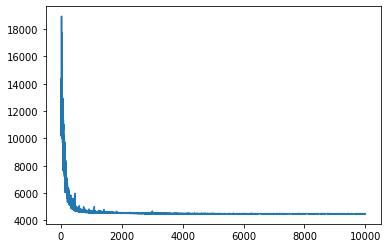

In [9]:
import matplotlib.pyplot as plt
plt.plot(variational_fit['loss'])

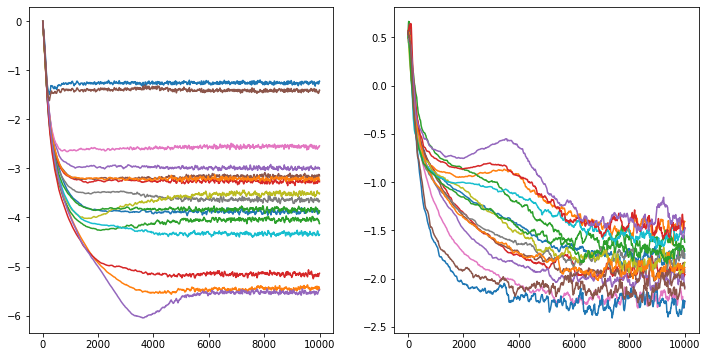

In [10]:
rate_var_traces = variational_fit['params'][-2:] # TODO: How can we make sure we get the right variables?
fig, axs = plt.subplots(ncols=len(rate_var_traces), figsize=(12, 6))
for ax, rate_var_trace in zip(axs, rate_var_traces):
    ax.plot(rate_var_trace)

In [11]:
import treeflow_pipeline.model

approx = treeflow_pipeline.model.reconstruct_approx(topology_file, variational_fit, yaml_input(prior_params_file), 'relaxed', clock_approx)

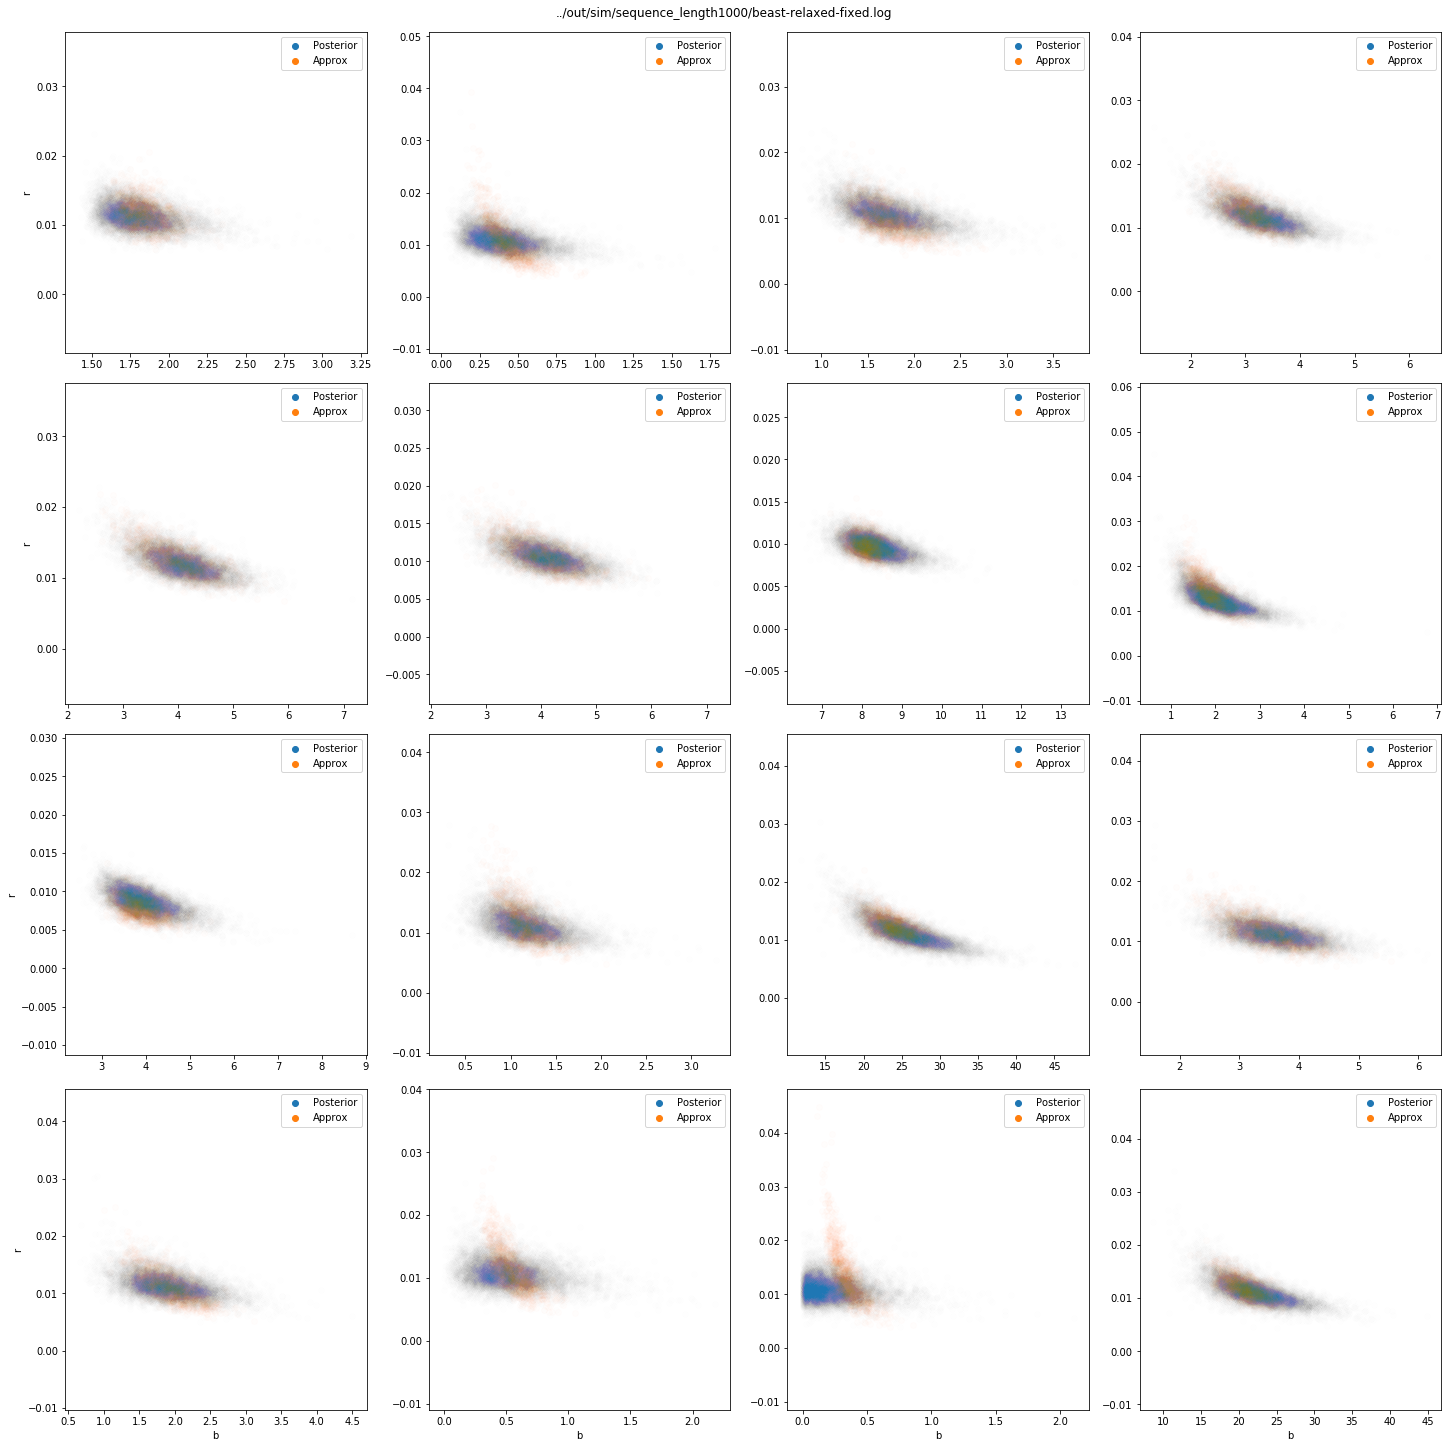

In [12]:
import treeflow.sequences

taxon_count = len(taxon_names)
n_cols = 4
n_branches = 2*taxon_count - 2
n_rows = n_branches // n_cols

def plot_approximation(approx):
    approx_samples = approx.sample(1000)
    approx_blens = treeflow.sequences.get_branch_lengths(approx_samples['tree'])
    approx_rates_t = approx_samples['clock_rate'].numpy() * approx_samples['rates'].numpy().T
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
    axs_flat = [ax for row in axs for ax in row]
    for ax, branch_blens, branch_rates, approx_blens, approx_rates in zip(axs_flat, blens_b.T, rates_b.T, approx_blens.numpy().T, approx_rates_t):
        ax.scatter(branch_blens, branch_rates, alpha=0.005, label='Posterior')
        ax.scatter(approx_blens, approx_rates, alpha=0.01, label='Approx')
        leg = ax.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

    for ax in axs[-1]:
        ax.set_xlabel('b')

    for row in axs:
        row[0].set_ylabel('r')
        
    plt.suptitle(trace_file);


plot_approximation(approx)
plt.savefig(plot_out_file)

In [13]:
import tensorflow as tf
init_node_heights = approx.model['tree'].height_distribution.node_height_distribution.bijector.forward(variational_fit['params'][-4][0])
init_heights = tf.concat([approx.model['tree'].height_distribution.leaf_heights, init_node_heights], 0)
treeflow.sequences.get_branch_lengths(dict(heights=init_heights, topology=approx.model['tree'].model['topology'].sample()))

<tf.Tensor: shape=(16,), dtype=float64, numpy=
array([1.87700307e+00, 4.73053071e-01, 1.99626271e+00, 4.17775408e+00,
       4.76723593e+00, 4.78537593e+00, 8.81945206e+00, 2.13977523e+00,
       3.81659820e+00, 1.38193964e+00, 3.11111037e+01, 3.77879815e+00,
       1.48288798e+00, 1.55753166e-01, 1.02973029e-04, 2.81758482e+01])>